# 01 / Данные

*Summary*:

-  Используем рыночные данные по ежедневным ценам и объёмам торгов из открытых источников

-  Убираем нестационарность временных рядов (например, с помощью дифферинцирования)

-  Собираем трансофрмированные признаки в общий контейнер

-  На его основе готовим признаки-скользящие окна, которые будут использоваться при обучении

-  Разделяем на обучающую, валидационную и тестовую выборки. К данным применяем масштабирование (фитим только на обучающей выборке, к валидационной и тестовой применяем).

- Признаки - скользящие окна выбранного размера по временным рядам

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os, sys

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('paper')

In [3]:
from pandas_datareader import data as pdr

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [5]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.marketData)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

In [6]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

# Параметры

In [7]:
INSTRUMENT = 'MSFT' # Microsoft corp
START_FROM = '2008-11-14'
END_DATE = '2020-01-01'
WINDOW_SIZE = 30
FORECAST_OFFSET=1
VAL_SPLIT = '2019-01-01'
TEST_SPLIT = '2019-06-01'

# Рыночные данные

Загружаем открытые рыночные данные через [`pandas_datareader`](https://pandas-datareader.readthedocs.io/en/latest/index.html "pandas-datareader &mdash; pandas-datareader documentation") из сервиса [Tiingo](https://www.tiingo.com "Stock Market Tools | Tiingo").

In [8]:
instr_df = pdr.get_data_tiingo(INSTRUMENT, api_key=os.environ.get('TIINGO_API_KEY'), start=START_FROM, end=END_DATE)

instr_df.tail()

close    high      low      open    volume  \
symbol date                                                                     
MSFT   2019-12-24 00:00:00+00:00  157.38  157.71  157.115  157.4800   8989150   
       2019-12-26 00:00:00+00:00  158.67  158.73  157.400  157.5511  14526927   
       2019-12-27 00:00:00+00:00  158.96  159.55  158.220  159.4500  18414352   
       2019-12-30 00:00:00+00:00  157.59  159.02  156.730  158.9865  16356720   
       2019-12-31 00:00:00+00:00  157.70  157.77  156.450  156.7700  18393383   

                                    adjClose     adjHigh      adjLow  \
symbol date                                                            
MSFT   2019-12-24 00:00:00+00:00  156.952587  157.281691  156.688307   
       2019-12-26 00:00:00+00:00  158.239084  158.298921  156.972533   
       2019-12-27 00:00:00+00:00  158.528297  159.116694  157.790306   
       2019-12-30 00:00:00+00:00  157.162017  158.588134  156.304353   
       2019-12-31 00:00:00+00:00  157.271718  157.341528  156.025113   

                                     adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                    
MSFT   2019-12-24 00:00:00+00:00  157.052316    8989150      0.0          1.0  
       2019-12-26 00:00:00+00:00  157.123223   14526927      0.0          1.0  
       2019-12-27 00:00:00+00:00  159.016966   18414352      0.0          1.0  
       2019-12-30 00:00:00+00:00  158.554725   16356720      0.0          1.0  
       2019-12-31 00:00:00+00:00  156.344244   18393383      0.0          1.0

In [9]:
instr_df.info();

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2800 entries, ('MSFT', Timestamp('2008-11-14 00:00:00+0000', tz='UTC')) to ('MSFT', Timestamp('2019-12-31 00:00:00+0000', tz='UTC'))
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        2800 non-null   float64
 1   high         2800 non-null   float64
 2   low          2800 non-null   float64
 3   open         2800 non-null   float64
 4   volume       2800 non-null   int64  
 5   adjClose     2800 non-null   float64
 6   adjHigh      2800 non-null   float64
 7   adjLow       2800 non-null   float64
 8   adjOpen      2800 non-null   float64
 9   adjVolume    2800 non-null   int64  
 10  divCash      2800 non-null   float64
 11  splitFactor  2800 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 292.7+ KB


Сохраняем данные и вычисляем индикаторы.

In [10]:
instr = MarketData.create_from_tiingo(INSTRUMENT, start=START_FROM, end=END_DATE)

Наши признаки: цены (открытие, максимум, минимум, закрытие), объём торгов, индикаторы.

In [11]:
instr.feature_names

['o',
 'h',
 'l',
 'c',
 'v',
 'ema14',
 'ema30',
 'macd',
 'macd_signal',
 'rsi14',
 'bband20_upper',
 'bband20_middle',
 'bband20_lower',
 'willr14',
 'stochk',
 'stochd',
 'adline',
 'adosc']

# Исходные признаки

И проверка их стационарности.

In [12]:
def plot_transformed_series(instrument, series, orig_display_name, transformed_display_name):
    plotHelpers.plot_transformed_timeseries(
        instrument.instrument,
        series,
        title_orig = orig_display_name,
        xlabel_orig = 'Date',
        ylabel_orig = orig_display_name,
        title_transformed = transformed_display_name,
        xlabel_transformed = 'Date',
        ylabel_transformed = transformed_display_name
    )

## Цены

### Цена закрытия

Скорректированная (adjusted) на корпоративные действия.
Наш основной признак и целевая переменная.

Сам ряд цен, очевидно, нестационарен:

In [13]:
instr.c.adf_report(True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         4.612571
P-Value                    1.000000
# Lags Used                8.000000
# Observations Used     2758.000000
Critical Value (1%)       -3.432723
Critical Value (5%)       -2.862589
Critical Value (10%)      -2.567328
dtype: float64


(1.0, False)

Переходим к логарифмическим доходностям. Уже это позволяет сделать ряд стациоарным:

In [14]:
close_log_returns = instr.c.transform(transforms={'ratios' : {}, 'ln' : {}})

close_log_returns.adf_report(True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.672111e+01
P-Value                 1.408311e-29
# Lags Used             1.000000e+01
# Observations Used     2.755000e+03
Critical Value (1%)    -3.432726e+00
Critical Value (5%)    -2.862590e+00
Critical Value (10%)   -2.567329e+00
dtype: float64


(1.408310959373375e-29, True)

#### Визуализация

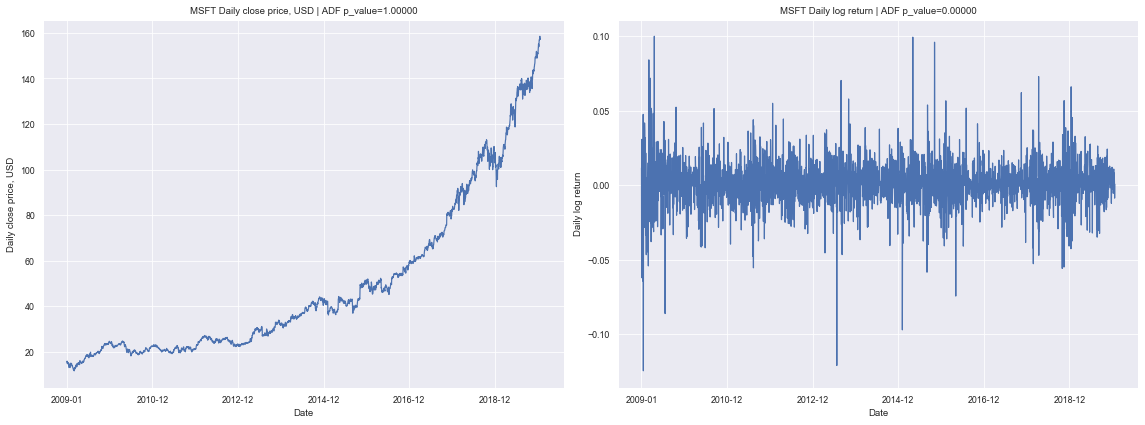

In [15]:
plot_transformed_series(instr, close_log_returns, 'Daily close price, USD', 'Daily log return')

### Цена открытия

Аналогично для цены открытия.

In [16]:
instr.o.adf_report()

(1.0, False)

In [17]:
instr.o.transform(transforms={'ratios' : {}, 'ln' : {}}).adf_report()

(0.0, True)

### Максимальная цена дня

In [18]:
instr.h.adf_report()

(1.0, False)

In [19]:
instr.h.transform(transforms={'ratios' : {}, 'ln' : {}}).adf_report()

(2.9516158209779155e-25, True)

### Минмальная цена дня

In [20]:
instr.l.adf_report()

(1.0, False)

In [21]:
instr.l.transform(transforms={'ratios' : {}, 'ln' : {}}).adf_report()

(0.0, True)

## Объём торгов

По критерию ADF он сразу оказался стационарным.

In [22]:
instr.v.adf_report()

(0.0024248123633458687, True)

Но после дифференцирования получается ещё лучше:

In [23]:
diff_order = 1

volume_diff =  instr.v.transform(transforms={'diffs': {'order': diff_order}})

volume_diff.adf_report(False)

(6.71124049737626e-30, True)

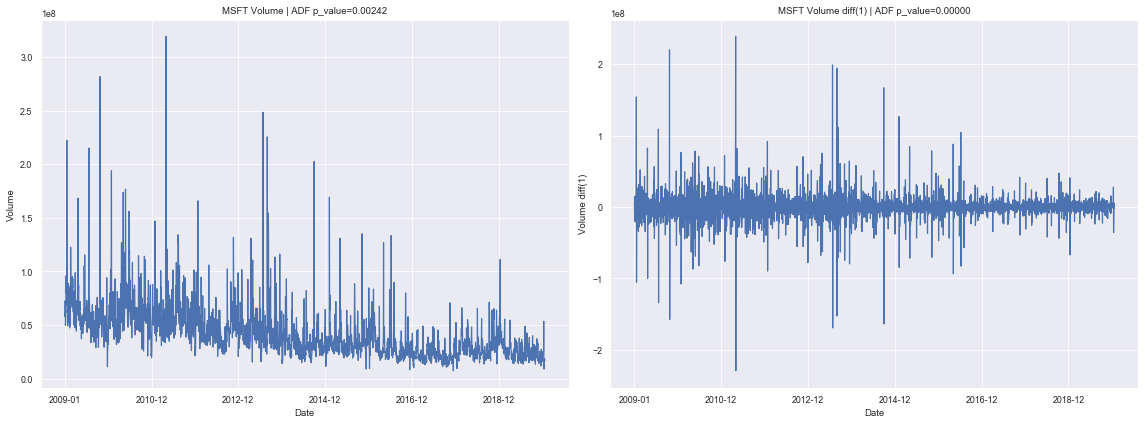

In [24]:
plot_transformed_series(instr, volume_diff, 'Volume', f'Volume diff({diff_order})')

## Индикаторы

### [MACD](https://www.investopedia.com/terms/m/macd.asp)

#### Визуализация

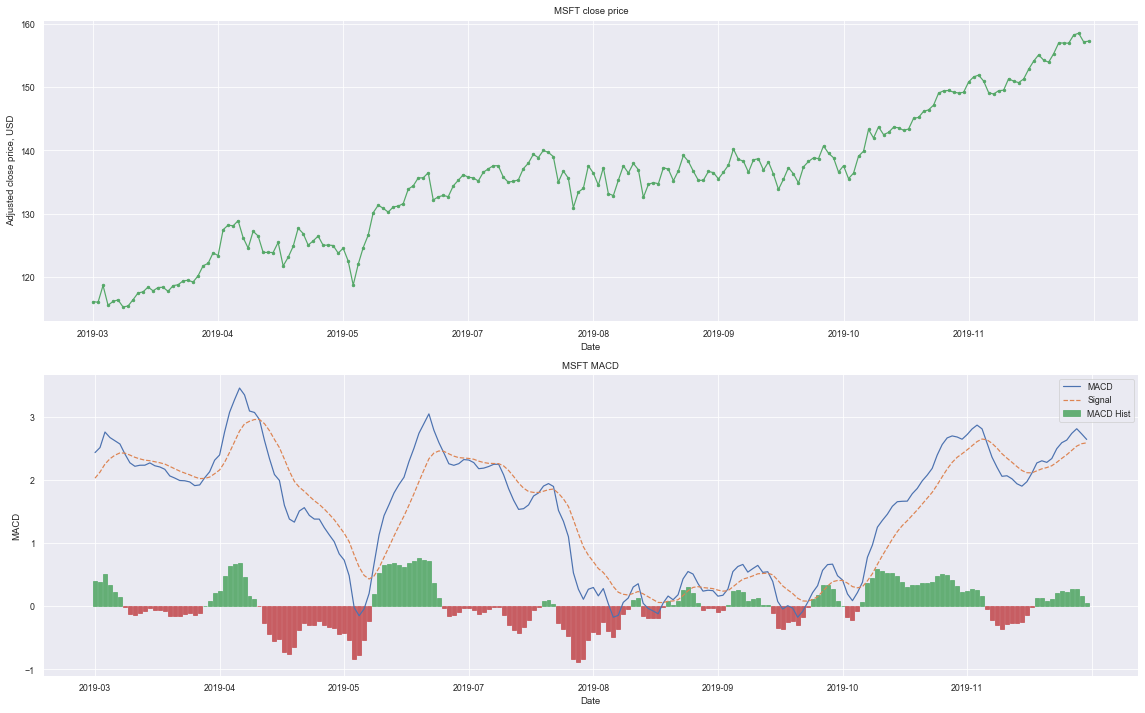

In [25]:
plotHelpers.plot_macd(instr, 200)

#### MACD

MACD по критерию ADF также сразу определяется как стационарный, но дифференцирование улучшает картину.

In [26]:
instr.macd.adf_report()

(9.270140304421096e-09, True)

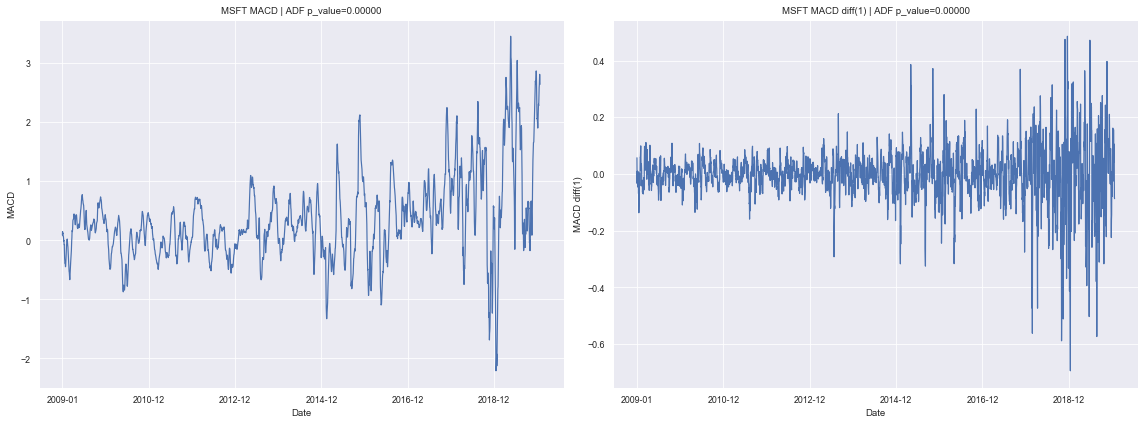

In [27]:
diff_order = 1

plot_transformed_series(instr,
                        instr.macd.transform(transforms={'diffs': {'order': diff_order}}),
                        'MACD', f'MACD diff({diff_order})')

Преобразование [Бокса-Кокса](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) позволяет немного сгладить дисперсию.

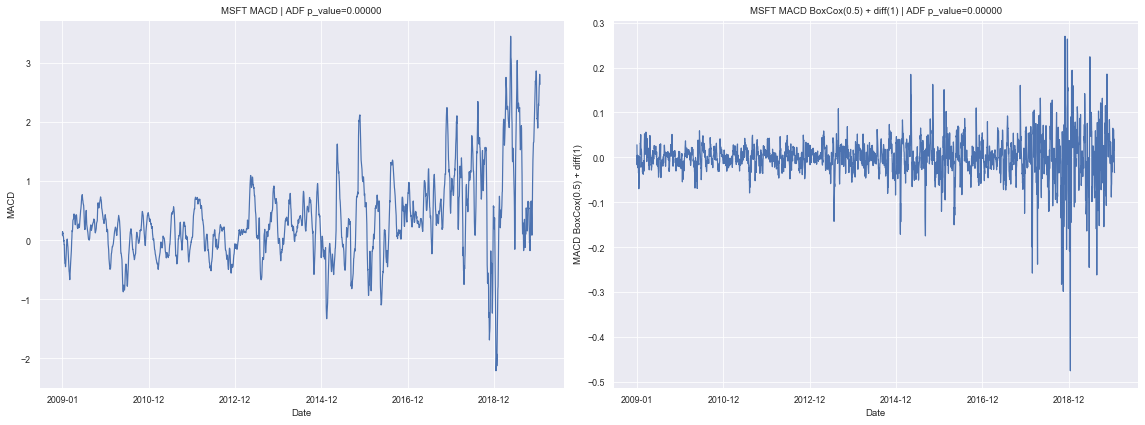

In [28]:
boxcox_lmbda = 0.5

plot_transformed_series(instr,
                        instr.macd.transform(transforms={'move': {'value': 4.},
                                                         'boxcox': {'lmbda': boxcox_lmbda},
                                                         'diffs': {'order': diff_order}}),
                        'MACD', f'MACD BoxCox({boxcox_lmbda}) + diff({diff_order})')

Для итогового признака ограничимся только диффиренцированием.

### [EMA](https://www.investopedia.com/terms/e/ema.asp)

In [29]:
instr.ema14.adf_report()

(1.0, False)

In [30]:
diff_order = 1

ema14_diff = instr.ema14.transform(transforms={'diffs' : {'order' : diff_order}})

ema14_diff.adf_report()

(9.830834206638931e-21, True)

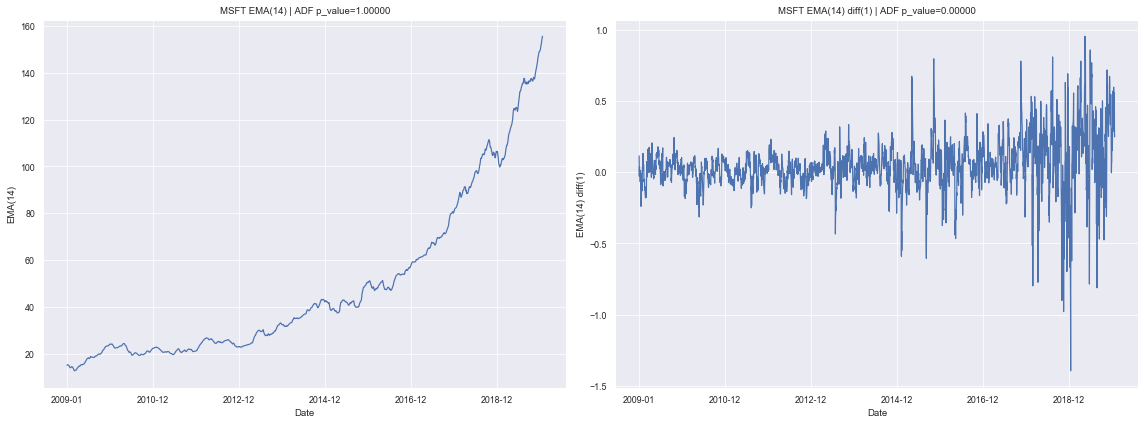

In [31]:
plot_transformed_series(instr,
                        ema14_diff,
                        'EMA(14)', f'EMA(14) diff({diff_order})')

### [RSI](https://www.investopedia.com/terms/r/rsi.asp)

In [32]:
instr.rsi14.adf_report()

(2.0018511125074804e-12, True)

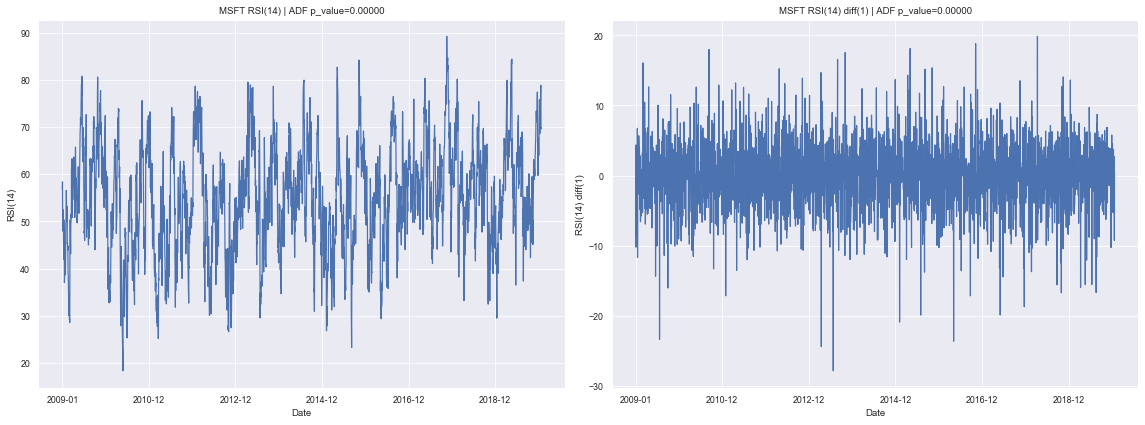

In [33]:
diff_order = 1

plot_transformed_series(instr,
                        instr.rsi14.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'RSI(14)', f'RSI(14) diff({diff_order})')

Здесь, наверное, тоже ничего специально делать не надо.

### [Bollinger Band](https://www.investopedia.com/terms/b/bollingerbands.asp)

In [34]:
instr.bband20_lower.adf_report(), instr.bband20_middle.adf_report(), instr.bband20_upper.adf_report()

((1.0, False), (1.0, False), (1.0, False))

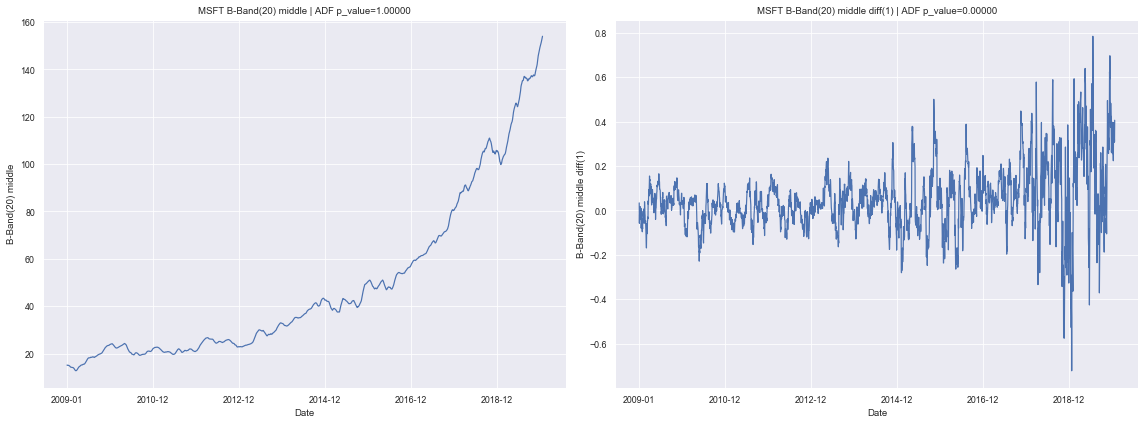

In [35]:
diff_order = 1

plot_transformed_series(instr,
                        instr.bband20_middle.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'B-Band(20) middle', f'B-Band(20) middle diff({diff_order})')

### [Williams %R](https://www.investopedia.com/terms/w/williamsr.asp)

In [36]:
instr.willr14.adf_report()

(1.3574371661867525e-19, True)

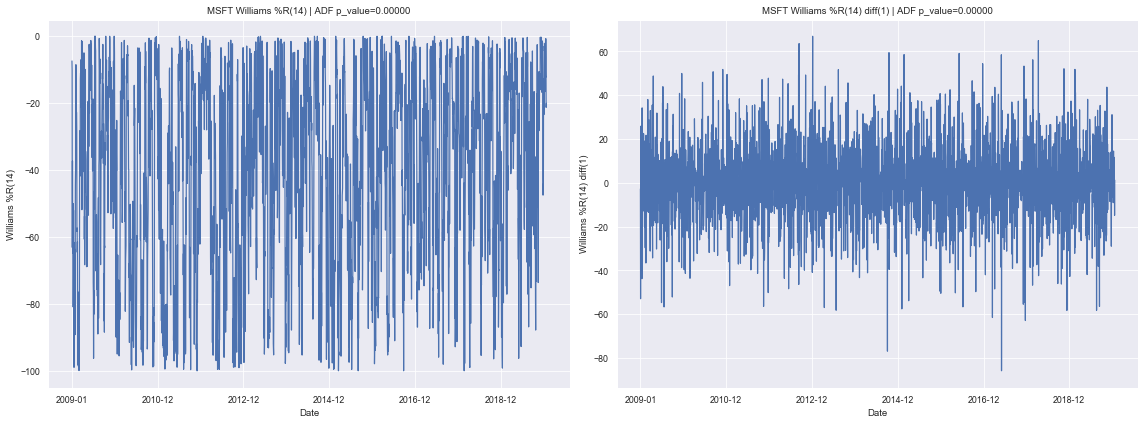

In [37]:
diff_order = 1

plot_transformed_series(instr,
                        instr.willr14.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'Williams %R(14)', f'Williams %R(14) diff({diff_order})')

Индикатор изначально выглядит как шум, так что с точки зрения стационарности чего-то дополнительного не требуется.

### [Stochastic oscillator](https://en.wikipedia.org/wiki/Stochastic_oscillator)

Стохастический осциллятор, возможно, по смыслу своего имени, стационарен.

In [38]:
instr.stochd.adf_report()

(2.472584043011467e-16, True)

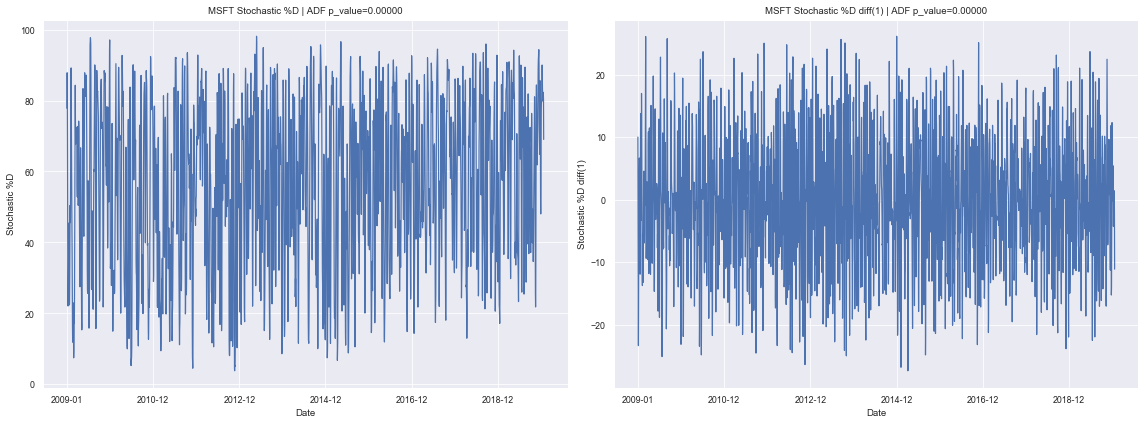

In [39]:
diff_order = 1

plot_transformed_series(instr,
                        instr.stochd.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'Stochastic %D', f'Stochastic %D diff({diff_order})')

### [Chaikin A/D Line](https://help.haasonline.com/api/examples/pshai-scripts/chaikin-ad-line)

In [40]:
instr.adline.adf_report()

(0.9753810688650325, False)

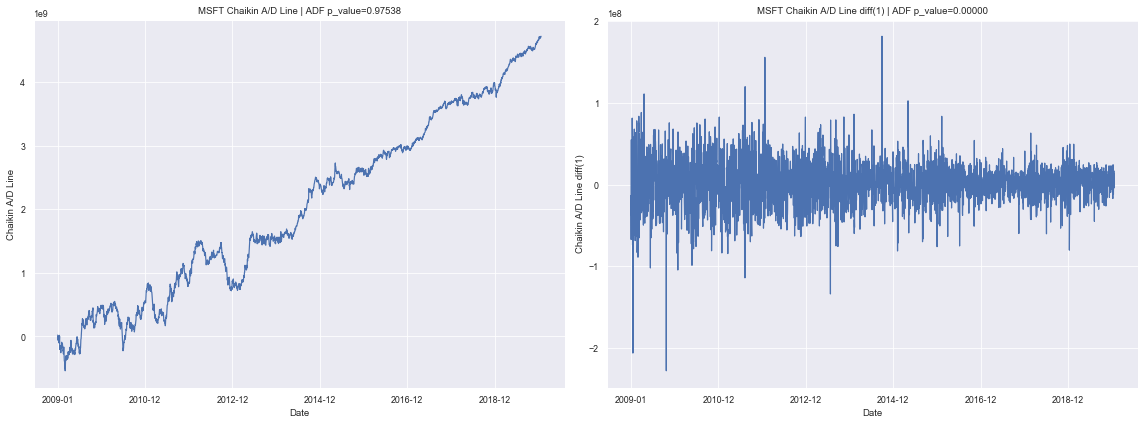

In [41]:
diff_order = 1

plot_transformed_series(instr,
                        instr.adline.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'Chaikin A/D Line', f'Chaikin A/D Line diff({diff_order})')

### [Chaikin A/D Oscillator](https://www.investopedia.com/terms/c/chaikinoscillator.asp)

In [42]:
instr.adosc.adf_report()

(1.5683009710345667e-25, True)

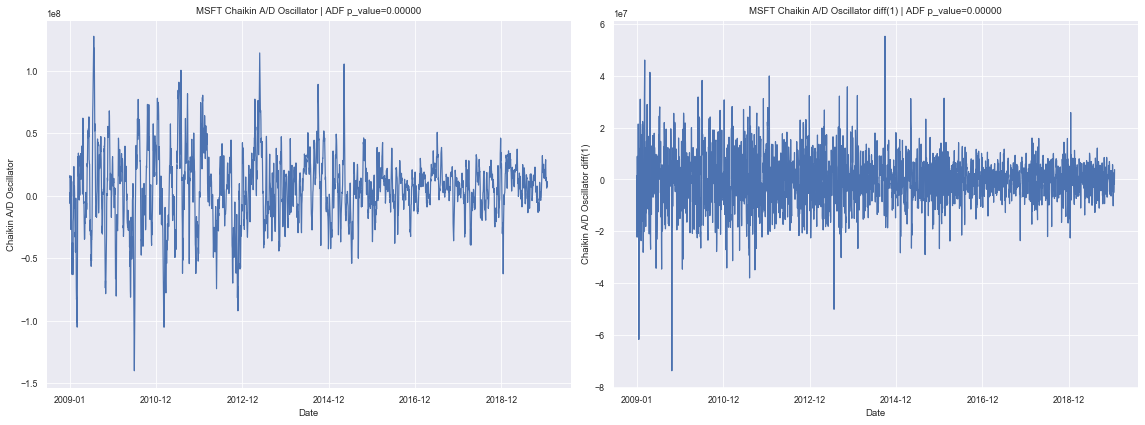

In [43]:
diff_order = 1

plot_transformed_series(instr,
                        instr.adosc.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'Chaikin A/D Oscillator', f'Chaikin A/D Oscillator diff({diff_order})')

# Трансформированные признаки

Применяем преобразования согласно исследованию, проведённому выше.

In [44]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'o': price_transformer(),
        'h': price_transformer(),
        'l': price_transformer(),
        'c': price_transformer(),
        'v': diff_transformer(1),
        'ema14': diff_transformer(1),
        'ema30': diff_transformer(1),
        'macd': diff_transformer(1),
        'macd_signal': diff_transformer(1),
        'rsi14': diff_transformer(1),
        'bband20_upper': diff_transformer(1),
        'bband20_middle': diff_transformer(1),
        'bband20_lower': diff_transformer(1),
        'willr14': identity_transformer(),
        'stochd': identity_transformer(),
        'stochk': identity_transformer(),
        'adline': diff_transformer(1),
        'adosc': diff_transformer(1)
    }
    return feature_transformations

Новый контейнер для трансформированных признаков:

In [45]:
instr_transformed = instr.select_transform(make_feature_selector())

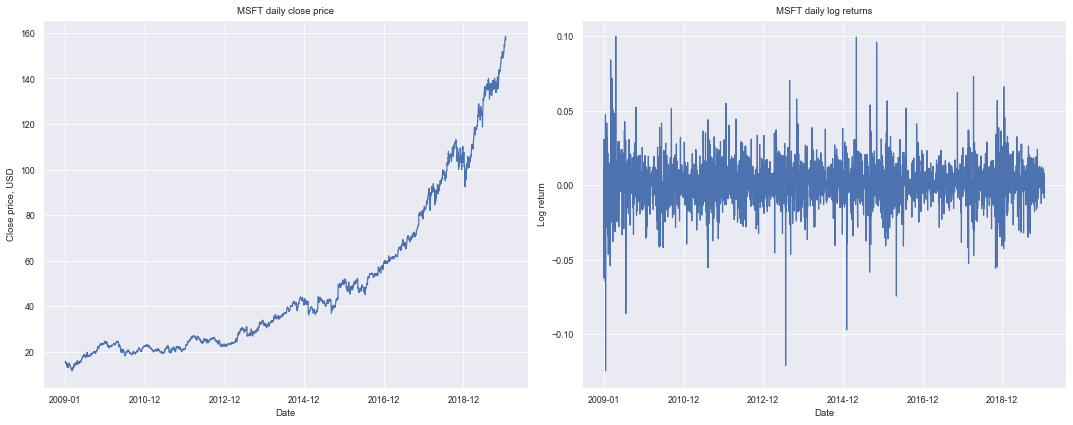

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plotHelpers.plot_timeseries(ax[0], instr.instrument, instr.c,
                            'daily close price', 'Date', 'Close price, USD')
plotHelpers.plot_timeseries(ax[1], instr_transformed.instrument, instr_transformed.c,
                            'daily log returns', 'Date', 'Log return')
fig.tight_layout()

# Разделение выборки

На обучение, валидацию и тест.

Так это выглядит для оригинальных данных:

In [47]:
train_unscaled, val_test_unscaled = instr.train_test_split(VAL_SPLIT, window_size=WINDOW_SIZE)

val_unscaled, test_unscaled = val_test_unscaled.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE)

len(train_unscaled), len(val_unscaled), len(test_unscaled)

(2515, 134, 178)

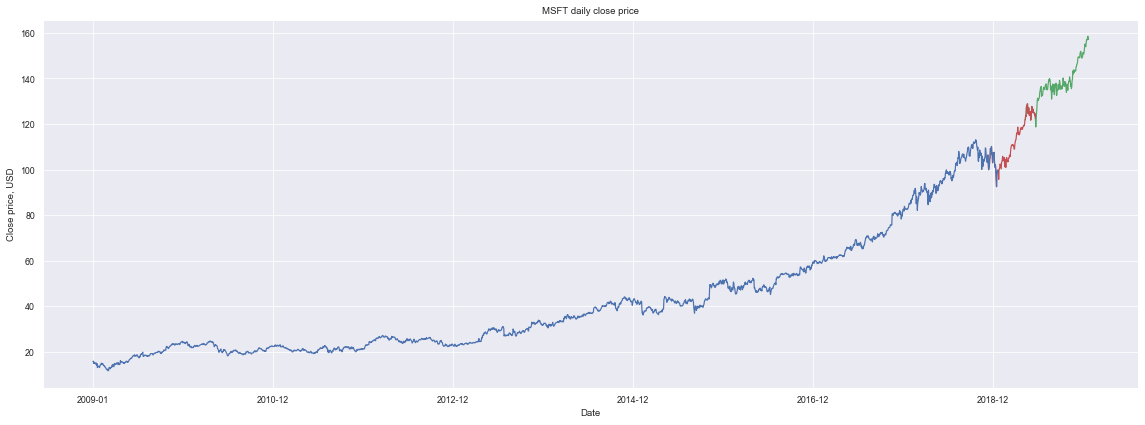

In [48]:
plotHelpers.plot_train_val_test_split(instr, train_unscaled, val_unscaled, test_unscaled, 'c',
                                      WINDOW_SIZE,'daily close price', 'Date', 'Close price, USD')
plt.tight_layout()

А так для трансформированных и отмасштабированных данных.

In [49]:
train_scaled, val_test_scaled = instr_transformed.train_test_split(VAL_SPLIT, window_size=WINDOW_SIZE,
                                                                   scaler=StandardScaler)

val_scaled, test_scaled = val_test_scaled.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(train_scaled), len(val_scaled), len(test_scaled)

(2514, 134, 178)

**Scaler** настраивается по данным обучающей выборки и потом применяется к валидационной и тестовой.

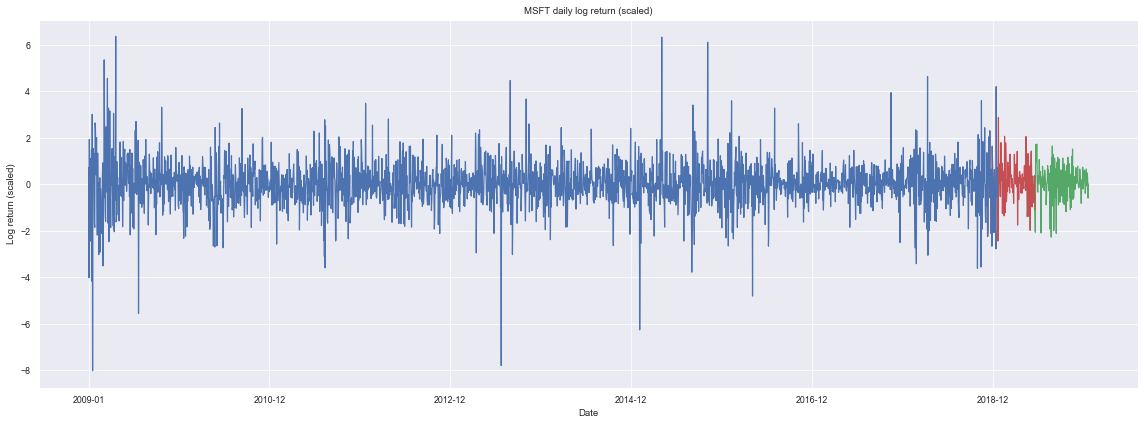

In [50]:
plotHelpers.plot_train_val_test_split(instr_transformed, train_scaled, val_scaled, test_scaled, 'c',
                                      WINDOW_SIZE,'daily log return (scaled)', 'Date', 'Log return (scaled)')
plt.tight_layout()

# Все признаки

Ряды, приведённые к стационарным.
На примере тестового датасета.

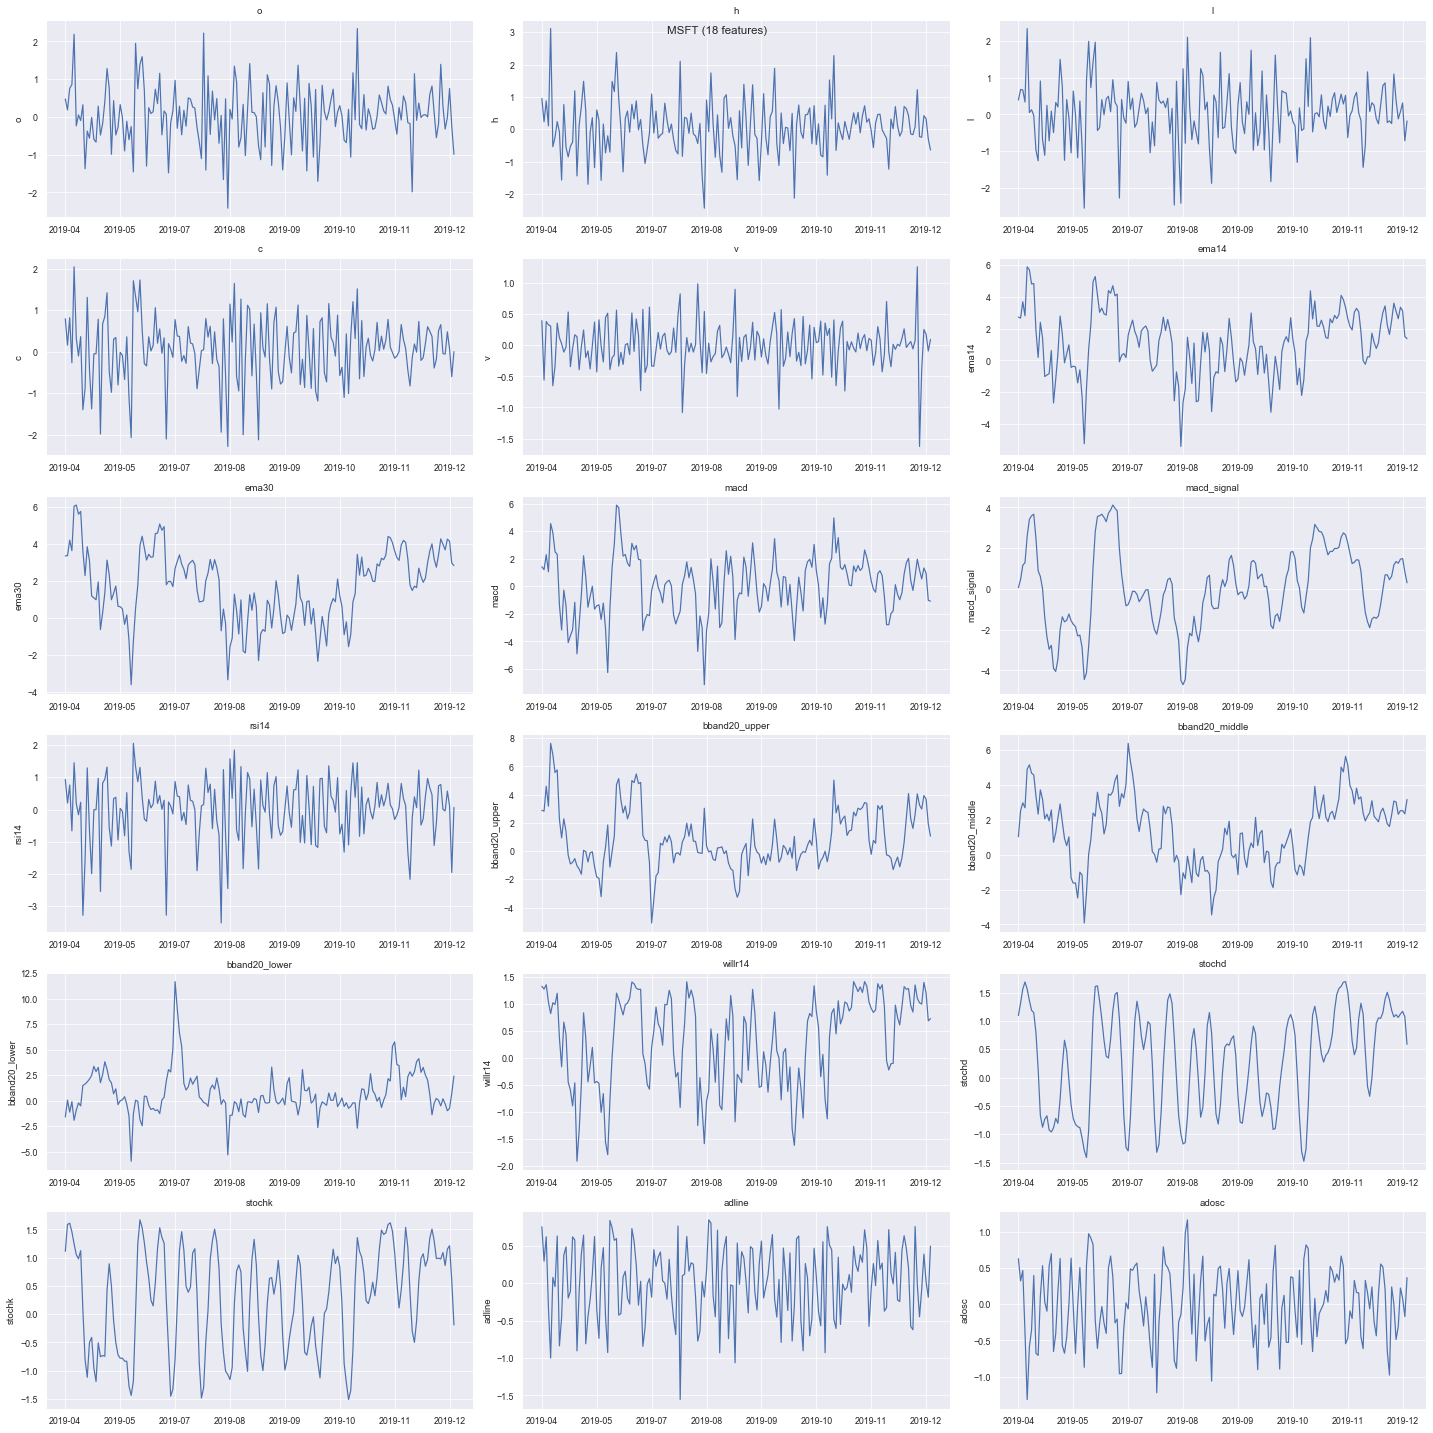

In [51]:
plotHelpers.plot_all_features(test_scaled)

# Скользящие окна

In [52]:
train_mwf = MovingWindowFeatures.create(train_scaled.c, [train_scaled], train_scaled.feature_names,
                                        WINDOW_SIZE, FORECAST_OFFSET)

train_mwf.features.shape

(2484, 30, 18)

Количество окон заданного размера для одного признака:

In [53]:
train_mwf.get_feature_windows('c').shape

(2484, 30)

Проверим, что данные совпадают для произвольного окна.

In [54]:
assert (train_mwf.get_feature_windows('c')[42] == train_scaled.c.data[42:42 + WINDOW_SIZE]).all()